We now consider a network containing inhibitory and neurons and recurrent connections.

# Tuning MF inputs

We first show that given a recurrent network of CA3 pyramidal cells and inhibitory interneurons, it is fairly straightforward to choose mossy fiber pathway inputs that yield localized place-tuned firing in the PCs.

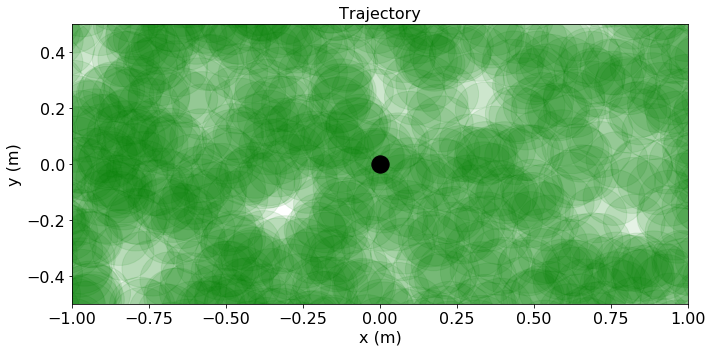

In [1]:
%reset -f
%matplotlib inline
from anim import build_frames
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
import numpy as np
import os

from aux import save_time_file
from ntwk import LIFNtwk
from plot import raster, set_font_size
from traj import Traj, InferredTraj, upstream_spks_from_traj

import PARAMETERS as P

cc = np.concatenate

N_PC = 900
N_INH = 100
N = N_PC + N_INH

BOX = (P.BOX_L, P.BOX_R, P.BOX_B, P.BOX_T)
ASPECT = (P.BOX_T - P.BOX_B) / (P.BOX_R - P.BOX_L)
FIG_SIZE = np.array([10, 10*ASPECT])

DUR = 2  # (s)
SPK_CT_ITVL = 1  # (s)
WINDOW_INFERRED = 0.05  # (s)

SYNS = ['AMPA', 'GABA']

SAVE_DIR = 'sims/mf_tuning'
SAVE_DIR_NO_RCR = 'sims/mf_tuning/no_rcr'


np.random.seed(2)

# build timestamp array and save
ts = np.arange(0, DUR, P.DT)
time_file = save_time_file(os.path.join(SAVE_DIR, 'time.npy'), ts)

# build place fields
pf_lb = [P.BOX_L - 0.1 * (P.BOX_R - P.BOX_L), P.BOX_B - 0.1 * (P.BOX_T - P.BOX_B)]
pf_ub = [P.BOX_R + 0.1 * (P.BOX_R - P.BOX_L), P.BOX_T + 0.1 * (P.BOX_T - P.BOX_B)]

centers = np.random.uniform(pf_lb, pf_ub, (N_PC, 2)).T
centers = cc([centers, np.nan*np.zeros((2, N_INH))], axis=1)

stds = P.L_PL * np.ones(centers.shape[1])

# build trajectory
xys = np.zeros((len(ts), 2))
traj = Traj(ts=ts, xys=xys)

# plot place fields
fig, ax = plt.subplots(1, 1, figsize=FIG_SIZE, tight_layout=True)

# rat's location
ax.scatter(0, 0, c='k', s=300, zorder=1)

# place fields
for center, std in zip(centers.T[:N_PC], stds[:N_PC]):
    ell = Ellipse(center, width=std, height=std, angle=0, color='g', alpha=0.1, zorder=0)
    ax.add_artist(ell)
    
ax.set_xlim(BOX[:2])
ax.set_ylim(BOX[2:])
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_title('Trajectory')

set_font_size(ax, 16)


def run_sim(save_dir, ws_rcr, ws_up, spks_up):
    """
    Function for running simulation fixing all parameters except
    those we plan on varying.
    """

    # build ntwk
    t_m = cc([P.T_M_PC*np.ones(N_PC), P.T_M_INH*np.ones(N_INH)])
    e_l = cc([P.E_L_PC*np.ones(N_PC), P.E_L_INH*np.ones(N_INH)])
    v_th = cc([P.V_TH_PC*np.ones(N_PC), P.V_TH_INH*np.ones(N_INH)])
    v_reset = cc([P.V_RESET_PC*np.ones(N_PC), P.V_RESET_PC*np.ones(N_INH)])
    
    es_rev = {'AMPA': P.E_A, 'GABA': P.E_G}
    ts_syn = {'AMPA': P.T_A, 'GABA': P.T_G}
    
    ntwk = LIFNtwk(
        t_m=t_m, e_leak=e_l, v_th=v_th, v_reset=v_reset, t_r=P.T_R,
        es_rev=es_rev, ts_syn=ts_syn, ws_rcr=ws_rcr, ws_up=ws_up)
    
    # run ntwk
    vs_init = e_l.copy()
    gs_init = {syn: np.zeros(N_PC+N_INH) for syn in SYNS}
    
    resp = ntwk.run(spks_up=spks_up, vs_init=vs_init, gs_init=gs_init, dt=P.DT)
    resp.place_field_centers = centers
    
    # save responses
    ntwk_file = resp.save(os.path.join(save_dir, 'ntwk.npy'))
    
    # make raster plots
    fig, axs = plt.subplots(2, 1, figsize=(15, 15))
    
    # place-tuned spk inputs
    spk_times_up = spks_up.nonzero()[0] * P.DT

    axs[0].scatter(spk_times_up, spks_up.nonzero()[1], marker='|', lw=1, c='k')
    axs[0].set_xlim(ts[0], ts[-1])
    axs[0].set_ylabel('Neuron')
    axs[0].set_title('Upstream spikes')

    # output spks
    raster(axs[1], time_file, ntwk_file, colors=(N_PC*['k'] + N_INH*['b']))

    axs[1].set_xlim(ts[0], ts[-1])
    axs[1].set_xlabel('t (s)')
    axs[1].set_ylabel('neuron')
    axs[1].set_title('Output spikes')
    
    for ax in axs:
        set_font_size(ax, 16)
    
    # calculate inferred traj
    inferred = InferredTraj(
        ntwk_file=ntwk_file,
        time_file=time_file,
        window=WINDOW_INFERRED)
    
    # get max firing rate
    fr_max = resp.spks[(ts >= (DUR-SPK_CT_ITVL))].sum(0).max() / SPK_CT_ITVL
    
    # get average activity spread
    spread = np.sqrt(np.nanmean(np.trace(inferred.covs, axis1=1, axis2=2)))

    return ntwk_file, fr_max, spread

### Run sim with no recurrent connectivity

Max firing rate = 21.00 Hz
Spread = 0.1059 m


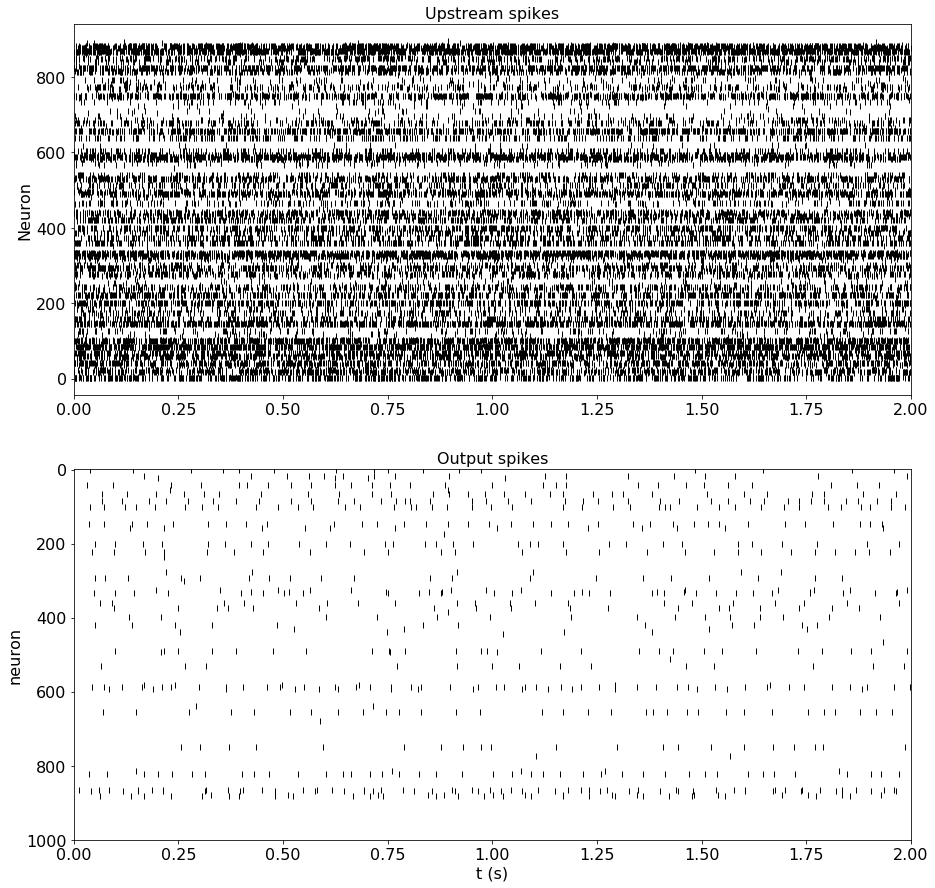

In [2]:
# generate upstream spks
max_rates = P.R_MAX_PL * np.ones(N_PC)
spks_up = upstream_spks_from_traj(ts, xys, centers[:, :N_PC], stds[:N_PC], max_rates=max_rates)

# set up cxns
ws_rcr = {'AMPA': np.zeros((N, N)), 'GABA': np.zeros((N, N))}
ws_up = {
    'AMPA': np.concatenate([P.W_A_PC_PL*np.eye(N_PC), np.zeros((N_INH, N_PC))]),
    'GABA': np.zeros((N, N_PC)),
}

ntwk_file, fr_max, spread = run_sim(SAVE_DIR_NO_RCR, ws_rcr, ws_up, spks_up)

print('Max firing rate = {0:.2f} Hz'.format(fr_max))
print('Spread = {0:.4f} m'.format(spread))

### Build animation

In [3]:
frames_ntwk = build_frames.ntwk_activity(
    save_prefix=os.path.join(SAVE_DIR_NO_RCR, 'ntwk/frame'),
    time_file=time_file,
    ntwk_file=ntwk_file,
    box=BOX,
    fps=60,
    resting_size=30,
    spk_size=400,
    amp=3,
    frames_per_spk=2,
    title='Network activity',
    x_label='x (m)',
    y_label='y (m)',
    fig_size=.7*FIG_SIZE)

In [4]:
from anim import create_mp4

movie = create_mp4(
    frames_ntwk, os.path.join(SAVE_DIR_NO_RCR, 'ntwk'), playback_fps=30, verbose=True)

Loading source images...


Source images loaded.
Generating movie and saving at "sims/mf_tuning/no_rcr/ntwk.mp4"...
Movie generated.
